# import library & check gpu

In [1]:
import torch
import pandas as pd
import numpy as np
import os
import tqdm
from torchsummary import summary
from matplotlib import pyplot as plt

In [2]:
torch.__version__

'1.10.2'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
torch.cuda.get_device_name(0)

'GeForce MX250'

# dataset

In [4]:
def create_datasets(batch_size):
    valid_size = 0.2

    # torch.FloatTensor로 변환
    train_csv = pd.read_csv('../data/train.csv')
    test_csv = pd.read_csv('../data/test.csv')

    train_data = torch.tensor(train_csv.to_numpy()).float()
    test_data = torch.tensor(test_csv.to_numpy()).float()

    # validation으로 사용할 trainning indices를 얻는다.
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = np.int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    vaild_data = train_data[valid_idx]
    train_data = train_data[train_idx]
    # train_sampler = SubsetRandomSampler(train_idx)
    # valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                            #    sampler=train_sampler,
                                               num_workers=0)

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                            #    sampler=valid_sampler,
                                               num_workers=0)

    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)

    return train_loader, test_loader, valid_loader


# define network

In [7]:
from torch import nn

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ELU(),

            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ELU(),
            nn.Dropout(0.3),
    
            nn.Linear(8, 8),
            nn.BatchNorm1d(8),
            nn.ELU(),
            nn.Dropout(0.3),

            nn.Linear(8, 4)
        )

    def forward(self, x):
        logits = self.network(x)
        return logits

In [8]:
model = net().to(device)
print(model)

net(
  (network): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=8, out_features=8, bias=True)
    (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ELU(alpha=1.0)
    (10): Dropout(p=0.3, inplace=False)
    (11): Linear(in_features=8, out_features=4, bias=True)
  )
)


In [9]:
summary(model, (32, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             528
       BatchNorm1d-2                   [-1, 16]              32
               ELU-3                   [-1, 16]               0
            Linear-4                    [-1, 8]             136
       BatchNorm1d-5                    [-1, 8]              16
               ELU-6                    [-1, 8]               0
           Dropout-7                    [-1, 8]               0
            Linear-8                    [-1, 8]              72
       BatchNorm1d-9                    [-1, 8]              16
              ELU-10                    [-1, 8]               0
          Dropout-11                    [-1, 8]               0
           Linear-12                    [-1, 4]              36
Total params: 836
Trainable params: 836
Non-trainable params: 0
---------------------------------------

# define earlystopping (will be converted to PyTorch Lightning)

In [10]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# train model

In [11]:
def train_model(model, batch_size, patience, n_epochs):

    # 모델이 학습되는 동안 trainning loss를 track
    train_losses = []
    # 모델이 학습되는 동안 validation loss를 track
    valid_losses = []
    # epoch당 average training loss를 track
    avg_train_losses = []
    # epoch당 average validation loss를 track
    avg_valid_losses = []

    # early_stopping object의 초기화
    early_stopping = EarlyStopping(patience = patience, verbose = True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, datas in enumerate(train_loader, 1):
            data = datas[:, 1:33].to(device)
            target = datas[:, 33].to(device).to(torch.int64)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()    
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            output = model(data)
            # calculate the loss
            loss = loss_fn(output, target)
            # backward pass: 모델의 파라미터와 관련된 loss의 그래디언트 계산
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())


        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for datas in valid_loader:
            data = datas[:, 1:33].to(device)
            target = datas[:, 33].to(device).to(torch.int64)
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            output = model(data)
            # calculate the loss
            loss = loss_fn(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print 학습/검증 statistics
        # epoch당 평균 loss 계산
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))


        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
        # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

   # best model이 저장되어있는 last checkpoint를 로드한다.
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [12]:
learning_rate = 0.001
batch_size = 128
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
patience = 30
n_epochs = 500

train_loader, test_loader, valid_loader = create_datasets(batch_size)

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

C:\Users\ktash\AppData\Local\Temp\ipykernel_12784\2951715554.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  split = np.int(np.floor(valid_size * num_train))


[  1/500] train_loss: 1.46889 valid_loss: 1.38860
Validation loss decreased (inf --> 1.388597).  Saving model ...
[  2/500] train_loss: 1.44024 valid_loss: 1.37926
Validation loss decreased (1.388597 --> 1.379261).  Saving model ...
[  3/500] train_loss: 1.40996 valid_loss: 1.36911
Validation loss decreased (1.379261 --> 1.369106).  Saving model ...
[  4/500] train_loss: 1.40664 valid_loss: 1.36024
Validation loss decreased (1.369106 --> 1.360239).  Saving model ...
[  5/500] train_loss: 1.38578 valid_loss: 1.35384
Validation loss decreased (1.360239 --> 1.353837).  Saving model ...
[  6/500] train_loss: 1.37851 valid_loss: 1.34770
Validation loss decreased (1.353837 --> 1.347696).  Saving model ...
[  7/500] train_loss: 1.37904 valid_loss: 1.34278
Validation loss decreased (1.347696 --> 1.342778).  Saving model ...
[  8/500] train_loss: 1.37002 valid_loss: 1.33726
Validation loss decreased (1.342778 --> 1.337258).  Saving model ...
[  9/500] train_loss: 1.37518 valid_loss: 1.33309
Val

# reslut visualization

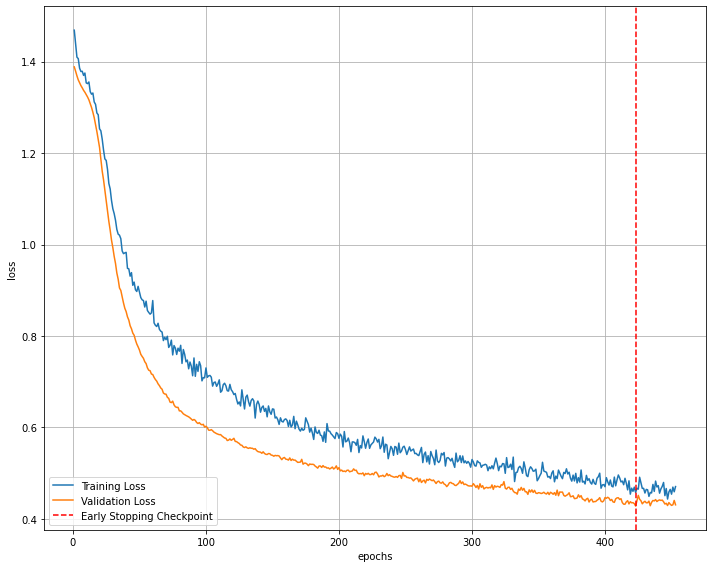

In [14]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [15]:
# test loss 및 accuracy을 모니터링하기 위해 list 초기화
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

model.eval() # prep model for evaluation
for datas in valid_loader:
    if len(datas) != batch_size:
        break
    # forward pass: 입력을 모델로 전달하여 예측된 출력 계산
    data = datas[:, 1:33].to(device)
    target = datas[:, 33].to(device).to(torch.int64)

    output = model(data)
    # calculate the loss
    loss = loss_fn(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # 출력된 확률을 예측된 클래스로 변환
    _, pred = torch.max(output, 1)
    # 예측과 실제 라벨과 비교
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # 각 object class에 대해 test accuracy 계산
    for i in range(batch_size):
        label = target[i].to('cpu').numpy()
        class_correct[label] += correct[i].item()
        class_total[label] +=1

# calculate and print avg test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.416504

Test Accuracy of     0: 91% (409/448)
Test Accuracy of     1: 78% (346/440)
Test Accuracy of     2: 87% (402/457)
Test Accuracy of     3: 72% (325/447)

Test Accuracy (Overall): 82% (1482/1792)


# make submission

In [16]:
import pandas as pd

sample_submission = pd.read_csv('../data/sample_submission.csv')

model.eval()

batch_index = 0

for i, data in enumerate(test_loader):
    data = data[:, 1:].to(device).float()
    outputs = model(data)
    batch_index = i * batch_size
    max_vals, max_indices = torch.max(outputs, 1)
    sample_submission.iloc[batch_index:batch_index + batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]

In [17]:
sample_submission

,id,target
0,1,0
1,2,2
2,3,1
3,4,1
4,5,2
...,...,...
9338,9339,3
9339,9340,1
9340,9341,2
9341,9342,0


In [18]:
sample_submission.to_csv('dacon_object_1.csv', index=False)